## Overview
* Quick Data Visualization/Interpretation
* Image Augmentation
* Imagenet
* Transfer Learning

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import Libraries

In [3]:
!pip install seaborn

In [4]:
#Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Data Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Loading the Data
In the code cell below, we load in the data and visualize one specific row. Additionally, we extract the labels from the input dataframe and one-hot encode them so that the shape is now (42000, 10) instead of (42000,).

Basic Example of One-hot Encoding:
![one-hot encoding](https://miro.medium.com/max/2474/1*ggtP4a5YaRx6l09KQaYOnw.png)

The only difference is we have 10 categories (numbers from 0-9) instead of colors. 

In [47]:
train_df = pd.read_csv('input/train.csv')
# train_df.shape()
orig_labels = train_df['label']
y = tf.keras.utils.to_categorical(orig_labels)[:2000,:]
print(np.array(y).shape)
# one-hot encoding
train_df.drop('label', axis=1, inplace=True)
train_df.head(1)

(2000, 10)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In order to apply convolutional nueral networks to the data, we need to shape it to the original shape of the image as opposed to the flattened data given. 

In [48]:
train_arr = np.array(train_df).reshape(-1, 28, 28, 1)[:2000,:,:,:]

In [49]:
train_arr.shape

(2000, 28, 28, 1)

**Data Imbalance**

Let's check to see if there is any evident data imbalance. 

Text(0.5, 0, 'Digit')

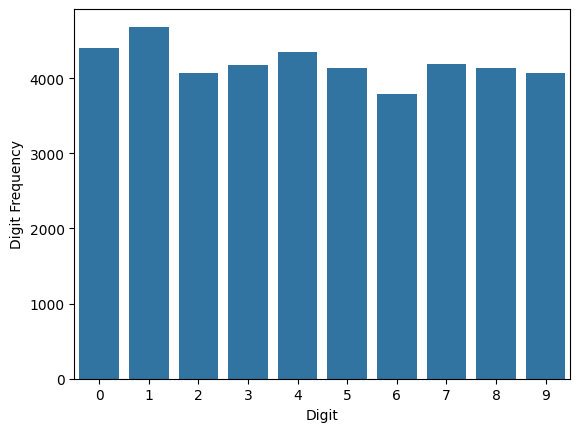

In [50]:
sns.barplot(x = orig_labels.unique(), y = orig_labels.value_counts())
plt.ylabel('Digit Frequency')
plt.xlabel('Digit')

The barplot shows that there is very little data imbalance, so we will not have to worry about that. 

In order to use the **pre-trained model** introduced later in the tutorial, we will need to convert each image into a size of at least (75, 75, 3). Due to the limited RAM, we will use the minimum size. Note that we also have to include three channels instead of just 1 (just copy the same channel 3 times) to make use of the pre-trained weights. 

In [51]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

def change_size(image):
    img = array_to_img(image, scale=False) #returns PIL Image
    img = img.resize((75, 75)) #resize image
    img = img.convert(mode='RGB') #makes 3 channels
    arr = img_to_array(img) #convert back to array
    return arr.astype(np.float64)

Let's create the final input array with **42000** images each with size *(75, 75, 3)*

In [52]:
train_arr_75 = [change_size(img) for img in train_arr]
del train_arr
train_arr_75 = np.array(train_arr_75)
train_arr_75.shape

(2000, 75, 75, 3)

## Data Augmentation

Data augmentation is one of the most fundamental and useful strategy when dealing with images. It becomes especially useful if we have few images. This is not the case with this dataset, but it will still help anyway. Fortunately, ```ImageDataGenerator``` from ```keras``` makes it extremely simple to apply these augmentations. However, it is important to be **careful** when deciding which augmentations to apply. 

For example, if we included the parameter ```vertical_flip=True```, then our 6 is no longer the same number. 

Let's investigate each of the augmentations one by one. 

**Width Shift Range**

This will shift the image horizontally by a specified amount. Setting the value to *0.2* simply means it can shift 20% of the total width. 

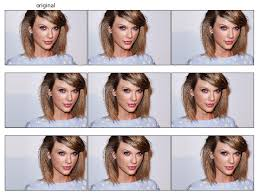

**Vertical Shift Range**

This is essentially the same as width shift range except in the vertical direction. 

**Zoom Range**

This augmentation simply makes the image smaller or bigger by the fraction specified. This value is kept small because we do not want the number to be cut out of the image. 

![zoom_range](https://miro.medium.com/max/2538/1*XCIOzkXS4E8yGvpRKiPTtQ.png)

In [53]:
image_gen = ImageDataGenerator(rescale=1./255, #easier for network to interpret numbers in range [0,1]
                              zoom_range=0.1,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              validation_split=0.2) # 80/20 train/val split

train_generator = image_gen.flow(train_arr_75, 
                                 y,
                                batch_size=32,
                                shuffle=True,
                                subset='training',
                                seed=42)
valid_generator = image_gen.flow(train_arr_75,
                                 y,
                                batch_size=16,
                                shuffle=True,
                                subset='validation')
del train_arr_75 #saves RAM

We split the data into the train and validation sets. Here is the distribution of the split data.

In [54]:
# sns.barplot(['train', 'valid'], [train_generator.n, valid_generator.n])

## Transfer Learning

Many features in general images are common and it is not worth starting to train from scratch. Usually the beginning layers in convolutional neural networks identify extremely basic features such as vertical and horizontal lines. This is what forms the backbone of tranfer learning. Using other peoples models, which have been trained on lots of data and are capable of identifying simple features, to fit your own data. 

**Imagenet**

Imagenet is one of the largest image databases in the world! Every year, they host a competition known as the *Imagenet Large Scale Visual Recognition Challenge (ILSVRC)*, where scientists from all over the world compete to create the best model. A couple years back, a group of researchers came up with the ResNet50, and now it's available to everyone! Learn more about the model here: [resnet50 info](https://www.mathworks.com/help/deeplearning/ref/resnet50.html#:~:text=ResNet%2D50%20is%20a%20convolutional,%2C%20pencil%2C%20and%20many%20animals).

In practice, it is best to use this model with image size (224, 224, 3) since the original model was trained with that size. However, for the purpose of this tutorial (75, 75, 3) will also work. Note that we specified the weights as ```'imagenet'```. This will automatically load those pretrained weights into the model. If we do not specify, the weights will be initialized randomly and we would be starting from scratch. 

In [55]:
model = Sequential()

model.add(tf.keras.applications.resnet50.ResNet50(input_shape = (75, 75, 3), 
                                include_top = False, 
                                weights = 'imagenet'))

model.add(L.Flatten())
model.add(L.Dense(30, activation='relu'))
model.add(L.Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#Do not use default learning rate since it is too high!

### Freezing Layers

The whole purpose of using the weights from imagenet was so that we wouldn't have spend training time to learn basic features. Instead, we use the ones already learned. To prevent the weights from being modified, we set the ```trainable``` parameter of the first several layers to ```False```. This will prevent the weights from changing during back propogation. 

Learn how to write back propogation from scratch [here](https://www.kaggle.com/saumandas/neural-networks-from-scratch-tutorial)!

In [56]:
for layer in model.layers[0].layers:
    if layer.name == 'conv5_block1_0_conv':
        break
    layer.trainable=False

In [57]:
history = model.fit(train_generator, validation_data=valid_generator, epochs=3, 
          steps_per_epoch=train_generator.n//train_generator.batch_size,
         validation_steps=valid_generator.n//valid_generator.batch_size)

Epoch 1/3


c:\Users\compe\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.1164 - loss: 2.8934 - val_accuracy: 0.1000 - val_loss: 3.0634
Epoch 2/3


c:\Users\compe\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.1138 - loss: 2.3018 - val_accuracy: 0.1200 - val_loss: 2.3024
